In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint

# time series specific
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    CutoffSplitter,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    # functions
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
    mean_squared_error,
    mean_squared_scaled_error,
    # classes
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
    MeanSquaredError,
    MeanSquaredScaledError,
)

from dsf_utils.preprocessing import process_raw_data, single_region_ts
from dsf_utils.evaluation import evaluate_forecasters, display_results
from dsf_utils.plotting import plot_cv_results
# custom model from:
# https://www.sktime.org/en/latest/developer_guide/add_estimators
from dsf_utils.models import ConstantValueForecaster

# warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (20,10)})
# set the numpy seed
np.random.seed(99)

# Data

In [3]:
# California time series
main_df = pd.read_csv("../DATA/ILINet.csv", na_values="X")
main_df = process_raw_data(main_df)
ts = single_region_ts(main_df, region="California")

# The rules of the game

We will assess the performance of the forecasting algorithms using a fixed length training window test performance of a 3-week ahead forecast in the following 8 cutt-off points:
* off-season: 2018-07-01, 2019-07-01
* flu-season start: 2018-10-01, 2019-09-01
* flus-season peak: 2018-12-15, 2019-11-24
* flu-season end: 2019-03-01, 2019-05-01

We'll evaluate forecast based on **RMSSE** and use naive forecasters as a baseline

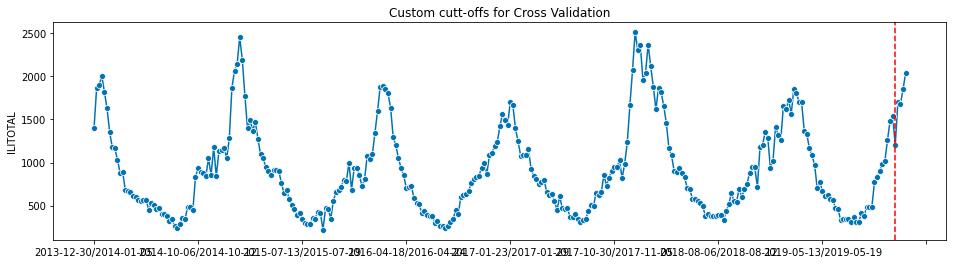

In [4]:
custom_cutoffs = np.array([
    len(ts[ts.index <= date]) 
    for date in 
    [
#         # off-season
#         "2018-07-01", 
#         "2019-07-01", 
#         # season start
#         "2018-10-01", 
#         "2019-10-01", 
#         # season peak
#         "2018-12-15", 
        "2019-11-24", 
        # season end
#         "2019-04-01", 
#         "2019-05-01"
    ]
])

# create the CV object
CV = CutoffSplitter(
    # custom cuttoffs
    cutoffs=custom_cutoffs, 
    # 3 step ahead forecast
    fh=np.arange(3)+1,
    # 5 years of training data
    window_length=5*52,
)

metric = MeanSquaredScaledError(square_root=True)

plot_series(ts)
for cutoff in custom_cutoffs: 
    plt.axvline(cutoff, color="red", linestyle="--")
plt.title("Custom cutt-offs for Cross Validation")
plt.show()

# Naive Benchmarks

In [5]:
forecasters_dict = {
    "Seasonal Naive": NaiveForecaster(sp=52), 
    "Naive": NaiveForecaster(sp=1)
}
metrics_dict = {"RMSSE": metric}
eval_df = evaluate_forecasters(ts, CV, forecasters_dict, metrics_dict)

display_results(eval_df)

ForecastingHorizon(['2019-12-02/2019-12-08', '2019-12-09/2019-12-15',
             '2019-12-16/2019-12-22'],
            dtype='period[W-SUN]', freq='W-SUN', is_relative=False)
ForecastingHorizon(['2019-12-02/2019-12-08', '2019-12-09/2019-12-15',
             '2019-12-16/2019-12-22'],
            dtype='period[W-SUN]', freq='W-SUN', is_relative=False)


Metric,RMSSE
Forecaster,
Naive,3.60
Seasonal Naive,3.12


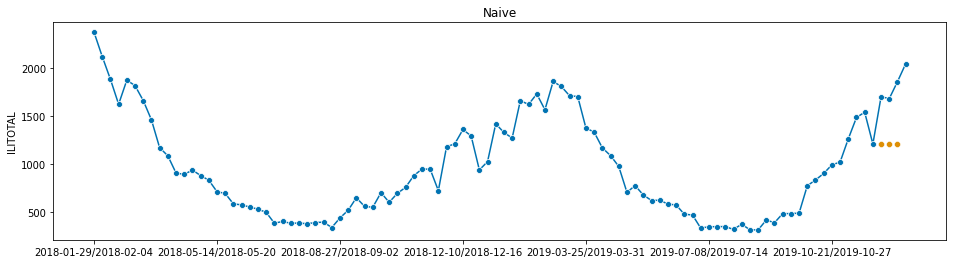

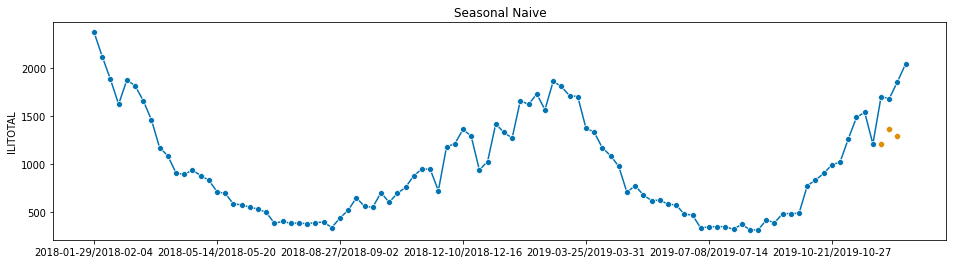

In [6]:
plot_cv_results(ts.iloc[-100:], eval_df)

# Statisitcal Methods - Exponential Smoothing

**Forecasting Principles and Practice - Exponential Smoothing chapter introduction:**  
Exponential smoothing was proposed in the late 1950s (Brown, 1959; Holt, 1957; Winters, 1960), and has motivated some of the most successful forecasting methods. Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight. This framework generates reliable forecasts quickly and for a wide range of time series, which is a great advantage and of major importance to applications in industry.  

**Exponential Smooting (ETS)** in it's simplest form **Simple Exponential Smoothing (SES)** is defined as:  
(insert formula )

The relatively new **Innovations State Space approach** (introduced in the ealry 2000s) for exponential smoothing has provided the statistical framework that the exponential smoothing lacked in the past. Under the innovations state space approaches exponential smooting methodas are capable of generating prediction intervals and much more.  

Under the state space approach there are 36 possible models: 

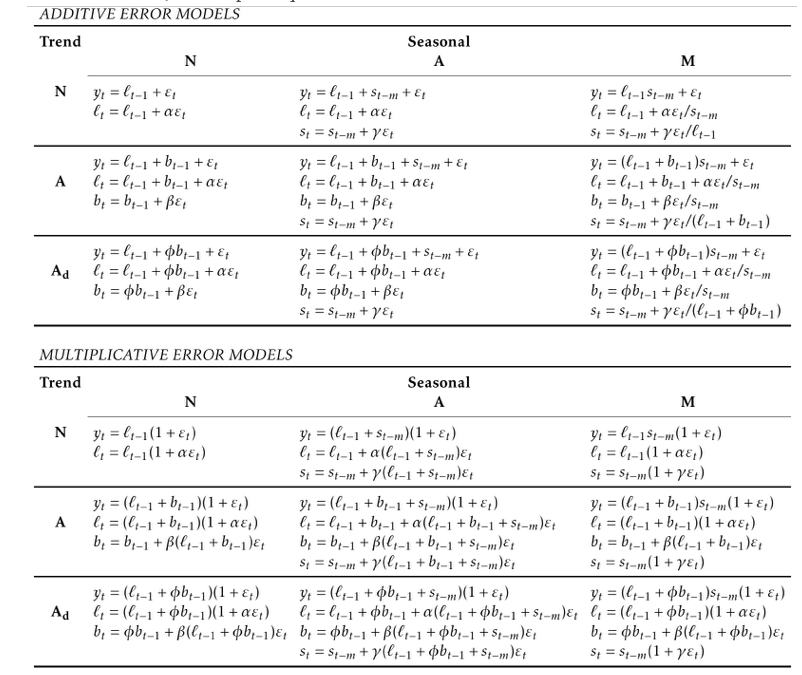

**Model selection** can be done either through cross-validation i.e. test all models and pick the best in a cross validation framework or through the use of information criteria. The most common Infromation Criteria used are:
* Akaike Information Criterion - AIC
* corrected Akaike Information Criterion - AICc
* Bayesian Information Criterion - BIC

For the above ICs - you can think of ICs as SSE with a penalty for number of fitted parameters of a model. For example, if SES and ETS(A,A,A) achieve the same SSE for a time series, then the model with the smallest IC will be SES as it achieves the same SSE with less parameters. The best model is the one that minimises the chosen IC.

References:  
1. [Forecasting Principles and Practice - Section 8](https://otexts.com/fpp3/ses.html)
2. [Forecasting with exponential smoothing: The state space approach.](https://robjhyndman.com/expsmooth/)

In [15]:
ts = single_region_ts(main_df, region="California")
custom_cutoffs = np.array(sorted([
    len(ts[ts.index <= date]) 
    for date in 
    [
        # off-season
#         "2018-07-01", 
#         "2019-07-01", 
        # season start
#         "2018-10-01", 
#         "2019-10-01", 
        # season peak
#         "2018-12-15", 
#         "2019-11-24", 
        # season end
        "2019-04-01", 
        "2019-06-01"
    ]], reverse=True))

# create the CV object
CV = CutoffSplitter(
    # custom cuttoffs
    cutoffs=custom_cutoffs, 
    # 3 step ahead forecast
    fh=np.arange(3)+1,
    # 5 years of training data
    window_length=5*52,
    strategy="refit"
)

metric = MeanSquaredScaledError(square_root=True)

forecasters_dict = {
    "AutoETS - AICc": AutoETS(auto=True, sp=52), 
#     "AutoETS - BIC": AutoETS(auto=True, sp=52),
#     "AutoETS - AIC": AutoETS(auto=True, sp=52),
}
metrics_dict = {"RMSSE": metric}
eval_df = evaluate_forecasters(ts, CV, forecasters_dict, metrics_dict)

display_results(eval_df)

TypeError: __init__() got an unexpected keyword argument 'strategy'

In [ ]:
ts = single_region_ts(main_df, region="California")
custom_cutoffs = np.array(sorted([
    len(ts[ts.index <= date]) 
    for date in 
    [
        # off-season
#         "2018-07-01", 
#         "2019-07-01", 
        # season start
#         "2018-10-01", 
#         "2019-10-01", 
        # season peak
#         "2018-12-15", 
#         "2019-11-24", 
        # season end
        "2019-04-01", 
        "2019-06-01"
    ]], reverse=True))

for cutoff in custom_cutoffs:
    # create the CV object
    CV = CutoffSplitter(
        # custom cuttoffs
        cutoffs=np.array([cutoff]), 
        # 3 step ahead forecast
        fh=np.arange(3)+1,
        # 5 years of training data
        window_length=5*52,
    )

    metric = MeanSquaredScaledError(square_root=True)

    forecasters_dict = {
        "AutoETS - AICc": AutoETS(auto=True, sp=52), 
    #     "AutoETS - BIC": AutoETS(auto=True, sp=52),
    #     "AutoETS - AIC": AutoETS(auto=True, sp=52),
    }
    metrics_dict = {"RMSSE": metric}
    eval_df = evaluate_forecasters(ts, CV, forecasters_dict, metrics_dict)

    display_results(eval_df)

ForecastingHorizon(['2019-06-10/2019-06-16', '2019-06-17/2019-06-23',
             '2019-06-24/2019-06-30'],
            dtype='period[W-SUN]', freq='W-SUN', is_relative=False)


In [17]:
ts = single_region_ts(main_df, region="California")
custom_cutoffs = np.array(sorted([
    len(ts[ts.index <= date]) 
    for date in 
    [
        # off-season
#         "2018-07-01", 
#         "2019-07-01", 
        # season start
#         "2018-10-01", 
#         "2019-10-01", 
        # season peak
#         "2018-12-15", 
#         "2019-11-24", 
        # season end
        "2019-04-01", 
        "2019-06-01"
    ]], reverse=False))

# create the CV object
CV = CutoffSplitter(
    # custom cuttoffs
    cutoffs=custom_cutoffs, 
    # 3 step ahead forecast
    fh=np.arange(3)+1,
    # 5 years of training data
    window_length=5*52
)

evaluate(
    forecaster=AutoETS(auto=True, sp=52),
    y=ts,
    cv=CV,
    strategy="refit",
    return_data=True,
    scoring=MeanSquaredScaledError(square_root=True),
)

ForecastingHorizon(['2019-04-15/2019-04-21', '2019-04-22/2019-04-28',
             '2019-04-29/2019-05-05'],
            dtype='period[W-SUN]', freq='W-SUN', is_relative=False)
PeriodIndex(['2019-04-15/2019-04-21', '2019-04-22/2019-04-28',
             '2019-04-29/2019-05-05'],
            dtype='period[W-SUN]', freq='W-SUN')
---- start ----
260
262
---- end ----
PeriodIndex(['2019-04-15/2019-04-21', '2019-04-22/2019-04-28',
             '2019-04-29/2019-05-05'],
            dtype='period[W-SUN]', freq='W-SUN')
2019-04-15/2019-04-21    1085.326390
2019-04-22/2019-04-28    1077.539000
2019-04-29/2019-05-05    1007.146902
Freq: W-SUN, dtype: float64
ForecastingHorizon(['2019-06-10/2019-06-16', '2019-06-17/2019-06-23',
             '2019-06-24/2019-06-30'],
            dtype='period[W-SUN]', freq='W-SUN', is_relative=False)
PeriodIndex(['2019-06-10/2019-06-16', '2019-06-17/2019-06-23',
             '2019-06-24/2019-06-30'],
            dtype='period[W-SUN]', freq='W-SUN')
---- start ----


KeyError: "None of [PeriodIndex(['2019-06-10/2019-06-16', '2019-06-17/2019-06-23',\n             '2019-06-24/2019-06-30'],\n            dtype='period[W-SUN]', freq='W-SUN')] are in the [index]"